# Chapter1 導入

いよいよ本丸、diffusionモデルの実装に進んでいきます。

まずはこの動画を見て復習しましょう。</br>
https://drive.google.com/drive/folders/1cb4yW5FSh2Hzpyzd_E7raHZaamQtxty2

Diffusionモデルは、画像をノイズで徐々に「汚す」**拡散過程**と、ノイズから元の画像を復元する**逆拡散過程**で構成されたモデルです。

この際、逆拡散過程と言語を関連付ける「条件付き」を含めたdiffusionモデルがtext to imageを実現するうえで重要なのですが、今回の章ではそこは省き、Diffusionモデルそのものを学びます。

まずは基本となる数理をお勉強します。

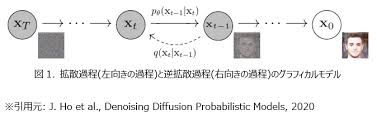

拡散モデルではよく上の図のようなノードとエッジのグラフ（マルコフモデル）でよく表されます。

右矢印がノイズ除去、左矢印がノイズ付与の方向です。

ここでは拡散過程を見ているので、見る矢印は、、、、左矢印ですね。つまり$q(x_t \mid x_{t-1})$を得たいわけです。

もし仮に完璧なノイズを生成する$q(x_t \mid x_{t-1})$があれば、この関数を噛ませれば写真を完璧なノイズに変換できます。

機械学習の世界は、このように「すべてを司るものを得ること」を目的とし、それを近似する確率分布を得ようとする試みが全てです。

さて、この$q(x_t \mid x_{t-1})$（ある$x_{t-1}$が与えられたときに$x_{t}$を得る確率）ですが、

面倒くさいので思い切って正規分布に近似してしまいます。
   $$
   q(x_t \mid x_{t-1}) = N\!\left(x_t;\, \sqrt{1-\beta_t}\,x_{t-1},\, \beta_t I \right)
   $$
適切なパラメータβを設定すれば、$q(x_t \mid x_{t-1})$が自動的に得られる、という体にしています。

計算しやすいように、このβを1から引いた1-βをαとしましょう。

式を見ているとαは「元画像をどれだけの割合で保持できるか」という割合になっていることが見て取れるなと思います。

逆に言うとβは「元画像の破損度合い」、つまり「ノイズの付与度合い」とみなすことが可能ですね。

もしこのノイズ付与度合いが大きすぎれば画像は一瞬で潰れてしまい、逆拡散の学習がうまくいきません。
逆に小さすぎると拡散が進まず、きれいにノイズから生成できなくなります。
したがって、時間ステップ $t$ に応じて適切にノイズ量 $\beta_t$ を調整することが重要です。

この正規分布への近似を用いると、高校数学１Aの条件付き確率の式から、$x_0$に$q(x_1 \mid x_{0})$、$q(x_2 \mid x_{1})$、$q(x_3 \mid x_{2})$、、、$q(x_t \mid x_{t-1})$を掛け算すると$x_t$が得られるはずです。


証明は端折りますが、大胆に端折りますが、この計算結果は以下のように表せます。

$
x_t = \sqrt{\bar{\alpha}_t}\, x_0 + \sqrt{1 - \bar{\alpha}_t}\, \epsilon,
$

で表されます。（$\epsilon$はガウスノイズ）

ただし、この$\bar{\alpha}_t$は累積積、つまり
$$
   \bar{\alpha}_t = \prod_{s=1}^{t} \alpha_s
$$
です。

あれ？ さっきの式を見て、$x_0$ を使うの？ $x_t$ のほうが順々にできるからやりやすいんじゃない？
と思った方もいるかもしれません。


実際には両方の書き方が可能です。

まずお察しの通り、逐次的にノイズを加える形は次のように表されます：

$
x_t = \sqrt{1-\beta_t}\, x_{t-1} + \sqrt{\beta_t}\, \epsilon_t.
$

これは「一歩前の状態 $x_{t-1}$」に基づいて $x_t$ を作る更新式です。

一方で、さきほど雑に説明したように、この式を繰り返し展開すると、
初期画像 $x_0$ と独立ノイズ $\epsilon$ を直接用いた形式

$
x_t = \sqrt{\bar{\alpha}_t}\, x_0 + \sqrt{1-\bar{\alpha}_t}\, \epsilon
$

も得られます。（この計算の途中に累積積が出てきます）

この閉形式のメリットは、
任意の時刻 $t$ に対応する $x_t$ を
「$x_0$ と $\epsilon$」から一発で生成できる点にあります。
t番目のものを調べるためにt-1番目までの値をすべて求める必要なく、サクッと求められるので、メモリ効率の観点などから好まれます。

したがって、実装上は「逐次式」でも拡散を進められるが、大人の事情で計算が効率的にできる下の式が利用されているというわけです。

さて式をよく見てみると、
$\sqrt{\bar{\alpha}_t}$ と $\sqrt{1 - \bar{\alpha}_t}$ が
元画像とノイズの混合比率を決定していることがわかります。

つまり、この$\bar{\alpha}_t$を得ることができれば、t番目にどのようなノイズが加えられるかがわかるというわけです。

次に示す linear_scheduler関数では、この
$
\sqrt{\bar{\alpha}_t}, \qquad \sqrt{1 - \bar{\alpha}_t}
$
を出力します。

In [1]:
#diffusionで利用する関数の定義
def linear_scheduler():
    T=1000
    t=torch.arange(0, T + 1,dtype=torch.float32)/T
    beta1, beta2 = 0.0001, 0.02
    beta_t = (beta2 - beta1) * t  + beta1  #A
    alpha_t = 1 - beta_t
    log_alpha_t = torch.log(alpha_t)
    alphabar_t = torch.cumsum(log_alpha_t, dim=0).exp()
    sqrtab = torch.sqrt(alphabar_t)  #B
    sqrtmab = torch.sqrt(1 - alphabar_t)  #C
    return {"sqrtab": sqrtab,"sqrtmab": sqrtmab}
print(linear_scheduler())

NameError: name 'torch' is not defined

変数の解説を入れます。

t: 時間ステップを 0〜1000 に正規化したもの（0.0, 0.001, ..., 1.0）。

β_t: 時間とともに増加するノイズ量。ここでは線形に増えるスケジュールを設定。

α_t = 1 - β_t: 「その時刻tにおける、きれいな画像を残す割合」。

α̅t : 累積的な「きれいさ」。すべてのステップで掛け合わせていった結果。

√α̅t : 元画像の寄与の大きさ（クリーン画像の重み）。

√(1-α̅t) : ノイズの寄与の大きさ。

つまり linear_scheduler() は「**各タイムステップで、元画像に対してノイズをどれくらい混ぜるか**」を返す関数です。

ここからこの関数を利用して画像にノイズを加えていきます。軽くテストしてみましょう。

（この数式の理解は不要ですが、気になる方は[こちらの書籍](https://www.oreilly.co.jp/books/9784814400591/)でかなり丁寧にあつかっているので手に取ってみると良いと思います。）

In [2]:
import matplotlib.pyplot as plt
import PIL
import numpy as np

#ノイズ付与関数
#画像に対して指定したステップ数分のノイズを加える。
def linear_noisy_image(image,timestep):
    alphabar_t=linear_scheduler()["sqrtab"][timestep]
    noisy=image*torch.sqrt(alphabar_t)+\
        torch.randn_like(image)*torch.sqrt(1 - alphabar_t)
    return torch.clip(noisy,min=-1,max=1)

In [4]:
#画像の読み込みと表示
imgs=[]
for name in ["apple","bird","cat","dog","fish","deer"]: #このリストに６つ要素を入れよう
    img=np.array(PIL.Image.open(f"/everyonesTextToImage/files/{name}.png"))
    img=torch.tensor(2*(img/255)-1)
    for timestep in [0,200,400,600,800,1000]:  #B
        imgs.append(linear_noisy_image(img,timestep)/2+0.5)
plt.figure(figsize=(12,8),dpi=100)

for i in range(24):
    plt.subplot(4,6,i+1)  #C
    plt.imshow(imgs[i])
    if i<6:
        plt.title(f't={200*(i%6)}',fontsize=12,c="r")
    plt.axis("off")
plt.tight_layout()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/everyonesTextToImage/files/apple.png'